In [ ]:
# Packages used
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as sp
import os
import pickle
import time
np.random.seed(100)

In [2]:
def load_dataset(name):
    X, y = [], []
    with open("{}".format(name), 'r') as f:
        for line in f.readlines():
            splitted = line.split(",")
            X.append(splitted[:-1])
            y.append(splitted[-1])
    X, y = np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)
    return X, y

In [3]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [4]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

In [5]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

In [6]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from test input and training input
    dist = allDistances(Xte, Xtr)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        # All the distances for the current test point
        idx_dist = dist[idx]
        # Sorting the indices of the distances
        order_idx_dist = np.argsort(idx_dist)
        
        # Getting the k lowest distence's indices
        k_idx_dist = order_idx_dist[:k]
        # Computing the mean of the output values of the corresponding training points
        Ypred[idx] = np.mean(Ytr[k_idx_dist])
    return Ypred


In [7]:
def separatingFkNN(Xtr, Ytr, k, Xte):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xte)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 500)
    yi = np.linspace(y.min(), y.max(), 500)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    #plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(x[Ytr==1], y[Ytr==1], c="#C59434", marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(x[Ytr==-1], y[Ytr==-1], c="#092C48", marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    #msg = 'Separating function, k='+str(k);
    #plt.title(msg)

In [8]:
def calcErrorKNN(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [9]:
def KFoldCVkNN(Xtr, Ytr, num_folds, hyperparam_list):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - hyperparam_list : List[int]
         the values of k (for k-NN) to try.
         
    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rnd_state = np.random.RandomState()
    # Ensures that k_list is a numpy array
    hyperparam_list = np.array(hyperparam_list)
    num_k = len(hyperparam_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds))
    val_errors = np.zeros((num_k, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rnd_state.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        # Hint: you can use boolean mask as index vector to split Xtr and Ytr
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]
        
        for k_idx, current_k in enumerate(hyperparam_list):
            # Compute the training error of the kNN classifier for the given value of k
            tr_errors[k_idx, fold_idx] = calcErrorKNN(kNNClassify(x_train, y_train, current_k, x_train), y_train)
            val_errors[k_idx, fold_idx] = calcErrorKNN(kNNClassify(x_train, y_train, current_k, x_val), y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best k (k which minimize mean validation error) and index of best k in hyperparam_list
    best_k = hyperparam_list[np.argmin(val_err_mean)]
    best_k_idx = np.argmin(val_err_mean)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

RLS 

In [10]:
def regularizedLSTrain(Xtr, Ytr, lam):
        n = Xtr.shape[0]
        I = np.eye(Xtr.shape[1])
        
        # Step 1: Build the left-hand side matrix A and the right-hand side matrix b
        A = Xtr.T @ Xtr + lam * n * I
        b = Xtr.T @ Ytr
        
        # Step 2: Compute the Cholesky decomposition of A
        L = np.linalg.cholesky(A)
        
        # Step 3: Solve the two triangular systems
        # First solve L @ y = b for y
        y = sp.solve_triangular(L, b, lower=True)
        
        # Then solve L.T @ w = y for w
        w = sp.solve_triangular(L.T, y, lower=False)
        
        return w

In [11]:
def regularizedLSTest(w, Xte):
    # Insert your code here
    Ypred = Xte @ w
    return Ypred

In [12]:
def calcErrorRLS(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

In [13]:
def KFoldCVRLS(Xtr, Ytr, KF, regpar_list):
    if KF <= 1:
        raise Exception("Please supply a number of fold > 1")

    # Ensures that regpar_list is a numpy array
    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_regpar, KF))
    val_errors = np.zeros((num_regpar, KF))

    for fold in range(KF):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        for idx, regpar in enumerate(regpar_list):
            # Set the indices in boolean mask for all validation samples to `True`
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            # Use the boolean mask to split X, Y in training and validation part

            X = Xtr[val_mask==False]   # training input 
            Y = Ytr[val_mask==False]  # training output 
            X_val = Xtr[val_mask==True]  # validation input
            Y_val = Ytr[val_mask==True]  # validation output
            
            # Train a RLS model for a single fold, and the given value of `regpar`
            currW = regularizedLSTrain(X, Y, regpar)
            
            # Compute the training error of the RLS regression for the given value of regpar
            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcErrorRLS(YpredTR, Y)

            # Compute the validation error of the RLS regression for the given value of regpar
            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcErrorRLS(YpredVAL, Y_val)
            
    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)
    
    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

Baseline Dataset

Best k:  1
Best lambda:  0.001


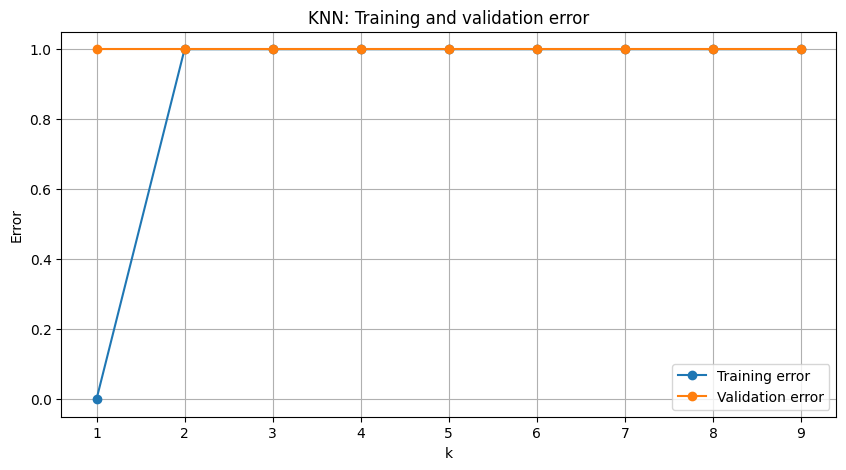

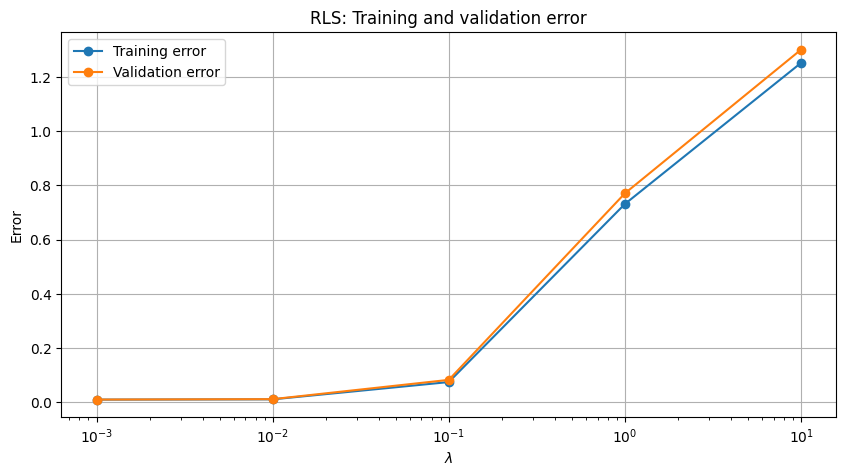

k-NN: Best k = 1, Training error = 0.0000, Training time = 0.8903 seconds
RLS: Best lambda = 0.001, Training error = 0.0099, Training time = 0.0010 seconds


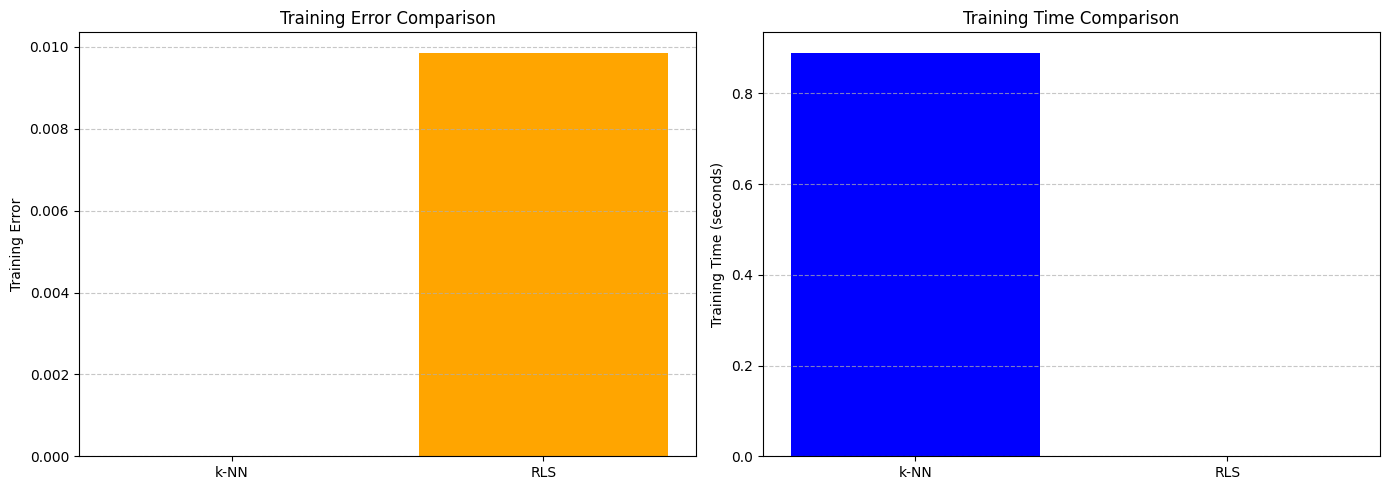

In [ ]:

Xtr3, Ytr3 = load_dataset("dataset_2_train")
KF = 5
k_list = [1, 2, 3, 4, 5, 6, 7,8, 9]
regpar_list = [0.001, 0.01, 0.1, 1, 10]

bestk, bestk_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr3, Ytr3, 5, k_list)
print("Best k: ", bestk)



best_lam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr3, Ytr3, 5, regpar_list)
print("Best lambda: ", best_lam)



plt.figure(figsize=(10, 5))
plt.plot(k_list, tr_err_mean, label="Training error", marker='o', linestyle='-')
plt.plot(k_list, val_err_mean, label="Validation error", marker='o', linestyle='-')
plt.xlabel("k")
plt.ylabel("Error")
plt.title("KNN: Training and validation error")
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(regpar_list, tr_mean, label="Training error", marker='o', linestyle='-')
plt.plot(regpar_list, val_mean, label="Validation error", marker='o', linestyle='-')
plt.xlabel("$\lambda$")
plt.ylabel("Error")
plt.xscale('log')
plt.title("RLS: Training and validation error")
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

# Measure training time for k-NN with the best k
start_time = time.time()
Ypred_knn = kNNClassify(Xtr3, Ytr3, bestk, Xtr3)  # Train and predict on the training set
training_time_knn = time.time() - start_time
training_error_knn = calcErrorKNN(Ypred_knn, Ytr3)

# Measure training time for RLS with the best lambda
start_time = time.time()
w_rls = regularizedLSTrain(Xtr3, Ytr3, best_lam)  # Train the RLS model
Ypred_rls = regularizedLSTest(w_rls, Xtr3)  # Predict on the training set
training_time_rls = time.time() - start_time
training_error_rls = calcErrorRLS(Ypred_rls, Ytr3)

# Print results
print(f"k-NN: Best k = {bestk}, Training error = {training_error_knn:.4f}, Training time = {training_time_knn:.4f} seconds")
print(f"RLS: Best lambda = {best_lam}, Training error = {training_error_rls:.4f}, Training time = {training_time_rls:.4f} seconds")


# Data for bar plots
algorithms = ['k-NN', 'RLS']
training_errors = [training_error_knn, training_error_rls]
training_times = [training_time_knn, training_time_rls]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plot training errors in the first subplot
axes[0].bar(algorithms, training_errors, color=['blue', 'orange'])
axes[0].set_ylabel("Training Error")
axes[0].set_title("Training Error Comparison")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot training times in the second subplot
axes[1].bar(algorithms, training_times, color=['blue', 'orange'])
axes[1].set_ylabel("Training Time (seconds)")
axes[1].set_title("Training Time Comparison")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

More Points

Best k:  1
Best lambda:  0.001


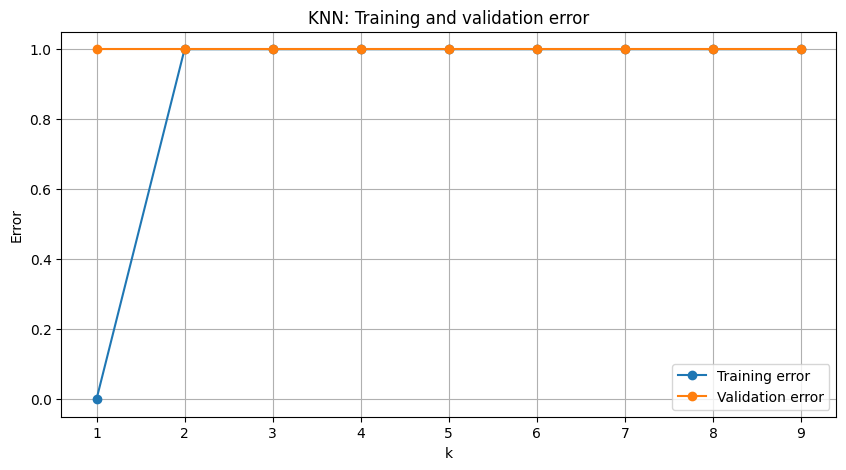

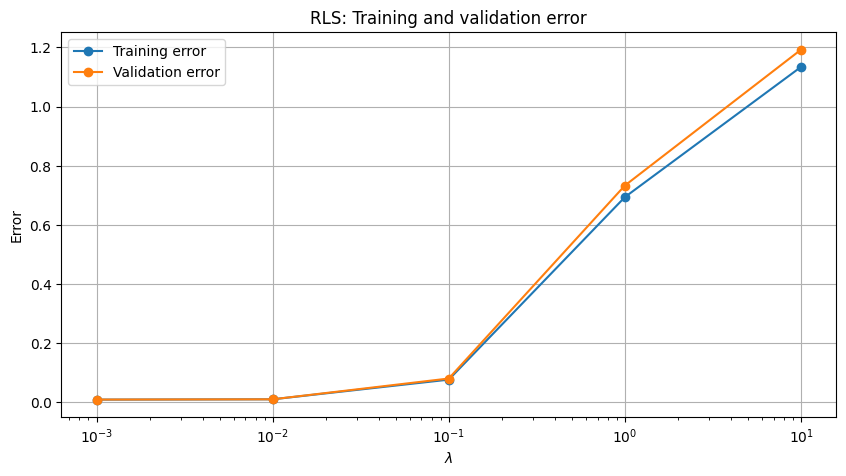

k-NN: Best k = 1, Training error = 0.0000, Training time = 4.4972 seconds
RLS: Best lambda = 0.001, Training error = 0.0094, Training time = 0.0000 seconds


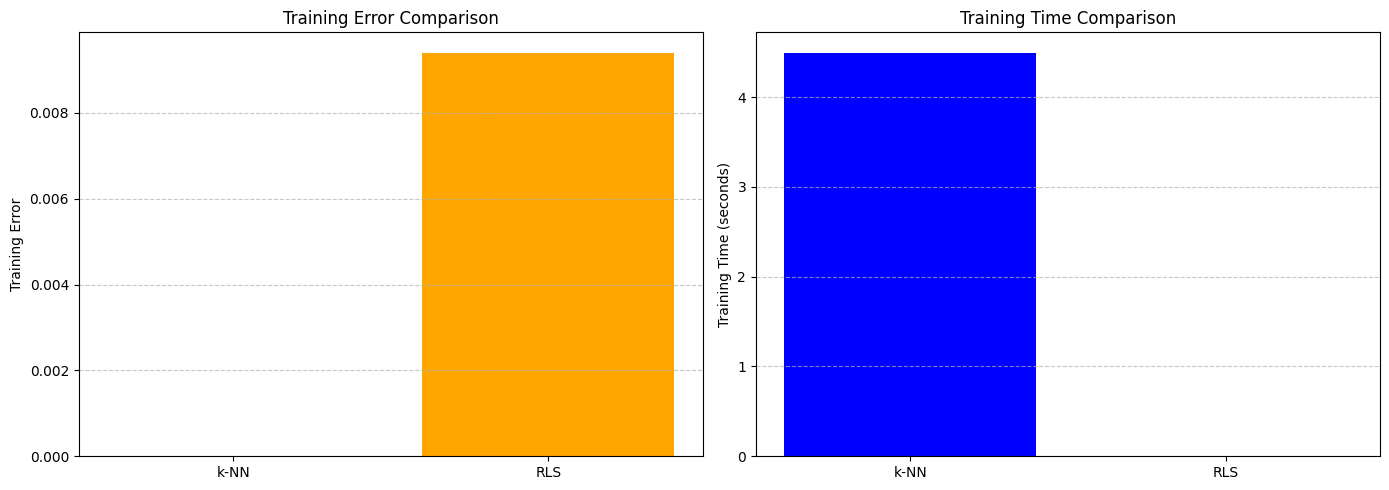

In [31]:
Xtr2, Ytr2 = load_dataset("dataset_3_train")
KF = 5
k_list = [1, 2, 3, 4, 5, 6, 7,8, 9]
regpar_list = [0.001, 0.01, 0.1, 1, 10]

bestk, bestk_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr2, Ytr2, 5, k_list)
print("Best k: ", bestk)



best_lam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr2, Ytr2, 5, regpar_list)
print("Best lambda: ", best_lam)



plt.figure(figsize=(10, 5))
plt.plot(k_list, tr_err_mean, label="Training error", marker='o', linestyle='-')
plt.plot(k_list, val_err_mean, label="Validation error", marker='o', linestyle='-')
plt.xlabel("k")
plt.ylabel("Error")
plt.title("KNN: Training and validation error")
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(regpar_list, tr_mean, label="Training error", marker='o', linestyle='-')
plt.plot(regpar_list, val_mean, label="Validation error", marker='o', linestyle='-')
plt.xlabel("$\lambda$")
plt.ylabel("Error")
plt.xscale('log')
plt.title("RLS: Training and validation error")
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

# Measure training time for k-NN with the best k
start_time = time.time()
Ypred_knn = kNNClassify(Xtr2, Ytr2, bestk, Xtr2)  # Train and predict on the training set
training_time_knn = time.time() - start_time
training_error_knn = calcErrorKNN(Ypred_knn, Ytr2)

# Measure training time for RLS with the best lambda
start_time = time.time()
w_rls = regularizedLSTrain(Xtr2, Ytr2, best_lam)  # Train the RLS model
Ypred_rls = regularizedLSTest(w_rls, Xtr2)  # Predict on the training set
training_time_rls = time.time() - start_time
training_error_rls = calcErrorRLS(Ypred_rls, Ytr2)

# Print results
print(f"k-NN: Best k = {bestk}, Training error = {training_error_knn:.4f}, Training time = {training_time_knn:.4f} seconds")
print(f"RLS: Best lambda = {best_lam}, Training error = {training_error_rls:.4f}, Training time = {training_time_rls:.4f} seconds")


# Data for bar plots
algorithms = ['k-NN', 'RLS']
training_errors = [training_error_knn, training_error_rls]
training_times = [training_time_knn, training_time_rls]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plot training errors in the first subplot
axes[0].bar(algorithms, training_errors, color=['blue', 'orange'])
axes[0].set_ylabel("Training Error")
axes[0].set_title("Training Error Comparison")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot training times in the second subplot
axes[1].bar(algorithms, training_times, color=['blue', 'orange'])
axes[1].set_ylabel("Training Time (seconds)")
axes[1].set_title("Training Time Comparison")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

Higher dimension

Best k:  1
Best lambda:  0.001


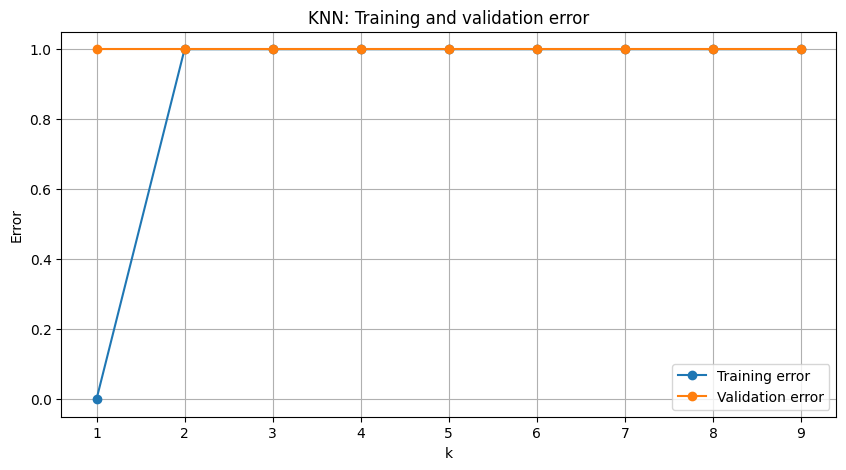

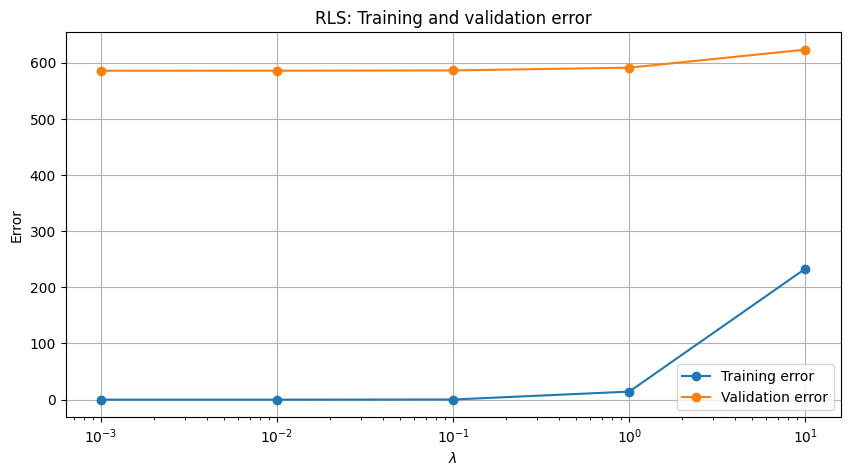

k-NN: Best k = 1, Training error = 0.0000, Training time = 1.5116 seconds
RLS: Best lambda = 0.001, Training error = 0.0000, Training time = 3.1338 seconds


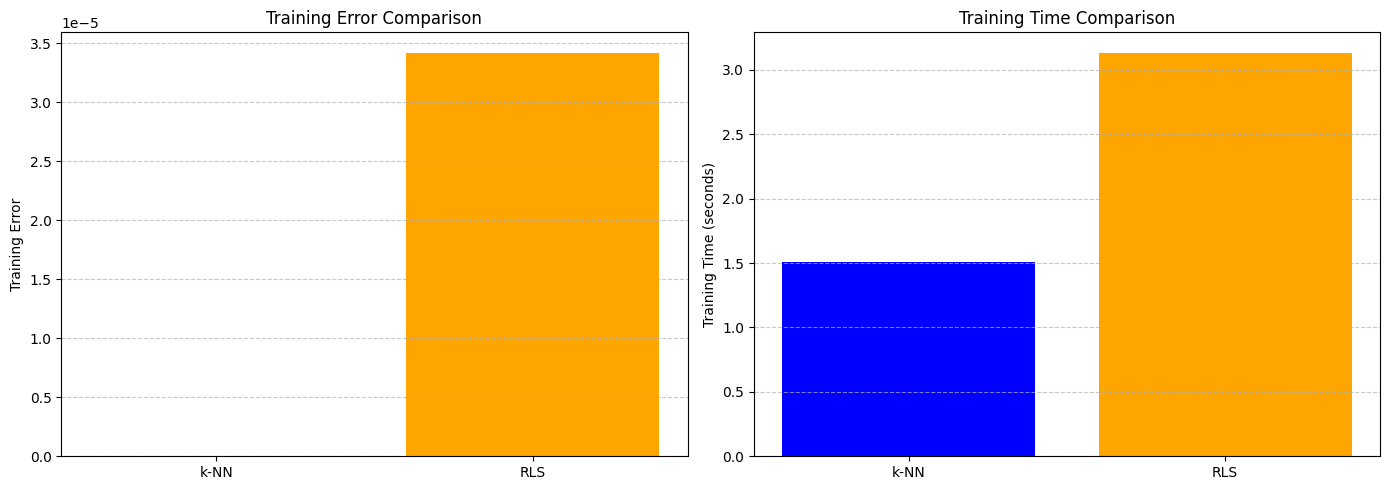

In [32]:
Xtr3, Ytr3 = load_dataset("dataset_5_train")
KF = 5
k_list = [1, 2, 3, 4, 5, 6, 7,8, 9]
regpar_list = [0.001, 0.01, 0.1, 1, 10]

bestk, bestk_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr3, Ytr3, 5, k_list)
print("Best k: ", bestk)



best_lam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr3, Ytr3, 5, regpar_list)
print("Best lambda: ", best_lam)



plt.figure(figsize=(10, 5))
plt.plot(k_list, tr_err_mean, label="Training error", marker='o', linestyle='-')
plt.plot(k_list, val_err_mean, label="Validation error", marker='o', linestyle='-')
plt.xlabel("k")
plt.ylabel("Error")
plt.title("KNN: Training and validation error")
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(regpar_list, tr_mean, label="Training error", marker='o', linestyle='-')
plt.plot(regpar_list, val_mean, label="Validation error", marker='o', linestyle='-')
plt.xlabel("$\lambda$")
plt.ylabel("Error")
plt.xscale('log')
plt.title("RLS: Training and validation error")
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

# Measure training time for k-NN with the best k
start_time = time.time()
Ypred_knn = kNNClassify(Xtr3, Ytr3, bestk, Xtr3)  # Train and predict on the training set
training_time_knn = time.time() - start_time
training_error_knn = calcErrorKNN(Ypred_knn, Ytr3)

# Measure training time for RLS with the best lambda
start_time = time.time()
w_rls = regularizedLSTrain(Xtr3, Ytr3, best_lam)  # Train the RLS model
Ypred_rls = regularizedLSTest(w_rls, Xtr3)  # Predict on the training set
training_time_rls = time.time() - start_time
training_error_rls = calcErrorRLS(Ypred_rls, Ytr3)

# Print results
print(f"k-NN: Best k = {bestk}, Training error = {training_error_knn:.4f}, Training time = {training_time_knn:.4f} seconds")
print(f"RLS: Best lambda = {best_lam}, Training error = {training_error_rls:.4f}, Training time = {training_time_rls:.4f} seconds")


# Data for bar plots
algorithms = ['k-NN', 'RLS']
training_errors = [training_error_knn, training_error_rls]
training_times = [training_time_knn, training_time_rls]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plot training errors in the first subplot
axes[0].bar(algorithms, training_errors, color=['blue', 'orange'])
axes[0].set_ylabel("Training Error")
axes[0].set_title("Training Error Comparison")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot training times in the second subplot
axes[1].bar(algorithms, training_times, color=['blue', 'orange'])
axes[1].set_ylabel("Training Time (seconds)")
axes[1].set_title("Training Time Comparison")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

In [ ]:
X_test,Y_test = load_dataset("your_dataset") # Load your test dataset here

# Measure training time for k-NN with the best k
start_time = time.time()
Ypred_knn = kNNClassify(Xtr3, Ytr3, bestk, X_test)  # Train and predict on the training set
training_time_knn = time.time() - start_time
training_error_knn = calcErrorKNN(Ypred_knn, Y_test)

# Measure training time for RLS with the best lambda
start_time = time.time()
w_rls = regularizedLSTrain(Xtr3, Ytr3, best_lam)  # Train the RLS model
Ypred_rls = regularizedLSTest(w_rls, Xtr3)  # Predict on the training set
training_time_rls = time.time() - start_time
training_error_rls = calcErrorRLS(Ypred_rls, Y_test)